# Generational changes in religious affiliaton, beliefs, and attitudes

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import pandas as pd
import numpy as np

import thinkstats2
import thinkplot
import utils

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5)
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1')

from statsmodels.discrete.discrete_model import MNLogit

Reading data from the [General Social Survey](https://gssdataexplorer.norc.org/projects/29853)

You can get my selected subset of variables from  https://gssdataexplorer.norc.org/extracts/21438/download

In [2]:
gss = utils.ReadGss('gss_religion_data')
print(gss.shape)
gss.head()

(62466, 11)


,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,god
0,1972,0,0,1949,23,0.4446,0,3,16,1,0
1,1972,0,0,1902,70,0.8893,0,2,10,2,0
2,1972,0,0,1924,48,0.8893,0,1,12,3,0
3,1972,0,0,1945,27,0.8893,0,5,17,4,0
4,1972,0,0,1911,61,0.8893,0,1,12,5,0


## Cleaning variables

Interpretation of the bible https://gssdataexplorer.norc.org/projects/29853/variables/1076/vshow

In [3]:
gss.bible.replace([4, 8, 9, 0], np.nan, inplace=True)

In [4]:
utils.values(gss, 'bible')

1.0    11185
2.0    15926
3.0     5929
Name: bible, dtype: int64

Confidence in the people running religious institutions https://gssdataexplorer.norc.org/projects/29853/variables/450/vshow

In [5]:
gss.conclerg.replace([8, 9, 0], np.nan, inplace=True)

In [6]:
utils.values(gss, 'conclerg')

1.0    11366
2.0    20886
3.0     8660
Name: conclerg, dtype: int64

Belief in God https://gssdataexplorer.norc.org/projects/29853/variables/1076/vshow

In [7]:
gss.god.replace([8, 9, 0], np.nan, inplace=True)
sum(gss.god.isnull())

40129

In [8]:
utils.values(gss, 'god')

1.0      673
2.0     1110
3.0     2286
4.0      900
5.0     3662
6.0    13706
Name: god, dtype: int64

Religious preference https://gssdataexplorer.norc.org/projects/29853/variables/287/vshow

In [9]:
gss.relig.replace([98, 99], np.nan, inplace=True)
sum(gss.relig.isnull())

269

In [10]:
utils.values(gss, 'relig')

1.0     35968
2.0     15181
3.0      1246
4.0      7254
5.0      1069
6.0       177
7.0        89
8.0        38
9.0       136
10.0      112
11.0      762
12.0       30
13.0      135
Name: relig, dtype: int64

Age https://gssdataexplorer.norc.org/projects/29853/variables/53/vshow

In [11]:
gss.age.replace([98, 99], np.nan, inplace=True)
sum(gss.age.isnull())

221

Year of birth https://gssdataexplorer.norc.org/projects/29853/variables/5507/vshow

In [12]:
gss.cohort.replace([9999], np.nan, inplace=True)
sum(gss.cohort.isnull())

221

Drop records if age or cohort is missing.

In [13]:
gss.dropna(subset=['age', 'cohort'], inplace=True)
gss.shape

(62244, 11)

We drop 222 records due to missing data.

In [14]:
62466 - 62244

222

Here's the distribution of ages.

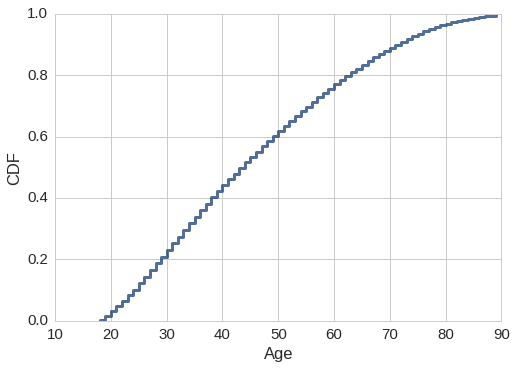

In [15]:
thinkplot.Cdf(thinkstats2.Cdf(gss.age))
thinkplot.Config(xlabel='Age', ylabel='CDF')

Group people into 5-year age groups.

In [16]:
gss['age_group'] = utils.RoundIntoBins(gss, 'age', 5) + 2.5

Here's the distribution of birth year.

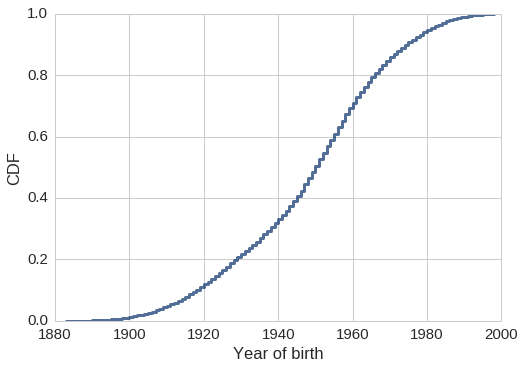

In [17]:
thinkplot.Cdf(thinkstats2.Cdf(gss.cohort))
thinkplot.Config(xlabel='Year of birth', ylabel='CDF')

Group people into 5- and 10-year bins by birth year.

In [18]:
gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5, low=4) + 2.5

In [19]:
grouped_cohort = gss.groupby(['cohort5'])
counts = grouped_cohort.relig.count()
counts

cohort5
1881.5       2
1886.5      37
1891.5     140
1896.5     365
1901.5     726
1906.5    1113
1911.5    1648
1916.5    2281
1921.5    2798
1926.5    3131
1931.5    3074
1936.5    3632
1941.5    4343
1946.5    5616
1951.5    6349
1956.5    6465
1961.5    5556
1966.5    4413
1971.5    3483
1976.5    2631
1981.5    2044
1986.5    1280
1991.5     658
1996.5     210
Name: relig, dtype: int64

In [20]:
gss['cohort10'] = utils.RoundIntoBins(gss, 'cohort', 10)

Here's the number of respondents in each year.

In [21]:
utils.values(gss, 'year')

1972    1608
1973    1500
1974    1478
1975    1485
1976    1493
1977    1523
1978    1525
1980    1459
1982    1845
1983    1592
1984    1467
1985    1527
1986    1463
1987    1807
1988    1477
1989    1533
1990    1372
1991    1514
1993    1601
1994    2986
1996    2898
1998    2827
2000    2809
2002    2751
2004    2803
2006    4492
2008    2013
2010    2041
2012    1969
2014    2529
2016    2857
Name: year, dtype: int64

## Recoding

Creating one-hots and categorical variables for the dependent variables.

In [22]:
def create_relig_vars(df):
    """Creates columns for religious categories.
    
    df: DataFrame
    """
    # lumping "Orthodox-Christian" and "Christian" with Protestant
    df['prot'] = (df.relig.isin([1,10,11]))
    df['cath'] = (df.relig==2)
    df['none'] = (df.relig==4)
    df['other'] = (df.relig.isin([3,5,6,7,8,9,12,13]))
    
    df['relig4'] = df.relig.copy()
    df.relig4.replace([10, 11], 1, inplace=True)
    df.relig4.replace([5,6,7,8,9,12,13], 3, inplace=True)

    varnames = ['prot', 'cath', 'none', 'other']
    df.loc[df.relig.isnull(), varnames + ['relig4']] = np.nan
    
create_relig_vars(gss)

In [23]:
sum(gss.relig.isnull())

249

In [24]:
utils.values(gss, 'relig4')

1.0    36728
2.0    15136
3.0     2900
4.0     7231
Name: relig4, dtype: int64

In [25]:
def create_belief_vars(df):
    """Creates columns for belief categories.
    
    df: DataFrame
    """
    df['nobelief'] = (df.god.isin([1, 2]))
    df['belief'] = (df.god.isin([3, 4, 5]))
    df['strongbelief'] = (df.god.isin([6]))
    
    df['belief3'] = df.god.copy()
    df.belief3.replace([1, 2], 1, inplace=True)
    df.belief3.replace([3, 4, 5], 2, inplace=True)
    df.belief3.replace([6], 3, inplace=True)

    varnames = ['strongbelief', 'belief', 'nobelief', 'belief3']
    df.loc[df.god.isnull(), varnames] = np.nan
    
create_belief_vars(gss)

In [26]:
sum(gss.god.isnull())

39961

In [27]:
utils.values(gss, 'belief3')

1.0     1780
2.0     6837
3.0    13666
Name: belief3, dtype: int64

In [28]:
def create_conf_vars(df):
    """Creates columns for confidence in religion categories.
    
    df: DataFrame
    """
    df['confident'] = (df.conclerg == 1)
    df['someconf'] = (df.conclerg == 2)
    df['noconf'] = (df.conclerg == 3)

    varnames = ['confident', 'someconf', 'noconf']
    df.loc[df.conclerg.isnull(), varnames] = np.nan
    
create_conf_vars(gss)

In [29]:
sum(gss.conclerg.isnull())

21466

In [30]:
utils.values(gss, 'conclerg')

1.0    11329
2.0    20816
3.0     8633
Name: conclerg, dtype: int64

In [31]:
def create_bible_vars(df):
    """Creates columns for bible interpretation categories.
    
    df: DataFrame
    """
    df['literal'] = (df.bible == 1)
    df['inspired'] = (df.bible == 2)
    df['legends'] = (df.bible == 3)

    varnames = ['literal', 'inspired', 'legends']
    df.loc[df.bible.isnull(), varnames] = np.nan
    
create_bible_vars(gss)

In [32]:
sum(gss.bible.isnull())

29291

In [33]:
utils.values(gss, 'bible')

1.0    11149
2.0    15887
3.0     5917
Name: bible, dtype: int64

In [34]:
def center_factors(df):
    """Center factors around their means.
    
    Add centered factors for the model.
    
    df: DataFrame
    """
    df['ones'] = np.ones_like(df.cohort)
    df['c'] = df.cohort - 1966
    df['a'] = df.age - 47
    df['c2'] = df.c**2
    df['a2'] = df.a**2
    df['ac'] = df.a * df.c

In [35]:
center_factors(gss)

## Resample

Resampling (bootstrapping to be more specific) to account for sampling weights.

In [36]:
sample = utils.ResampleByYear(gss)
sample.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,...,noconf,literal,inspired,legends,ones,c,a,c2,a2,ac
0,1972,NaN,NaN,1910.0,62.0,1.3339,0,3.0,12,1539,...,NaN,NaN,NaN,NaN,1.0,-56.0,15.0,3136.0,225.0,-840.0
1,1972,NaN,NaN,1936.0,36.0,0.8893,0,2.0,6,826,...,NaN,NaN,NaN,NaN,1.0,-30.0,-11.0,900.0,121.0,330.0
2,1972,NaN,NaN,1918.0,54.0,0.8893,0,2.0,3,758,...,NaN,NaN,NaN,NaN,1.0,-48.0,7.0,2304.0,49.0,-336.0
3,1972,NaN,NaN,1900.0,72.0,1.3339,0,1.0,5,356,...,NaN,NaN,NaN,NaN,1.0,-66.0,25.0,4356.0,625.0,-1650.0
4,1972,NaN,NaN,1950.0,22.0,2.6679,0,5.0,13,1550,...,NaN,NaN,NaN,NaN,1.0,-16.0,-25.0,256.0,625.0,400.0


## Religious affiliation

In [37]:
def make_series_seq(grouped, varnames):
    """Compute the percentage in each category.
    
    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names
    
    returns: list of Series
    """
    return [grouped[var].mean() * 100 for var in varnames]

In [38]:
def plot_series_seq(series_seq, colors, labels):
    """Plots Series objects.
    
    series_seq: list of Series
    colors: list of string colors
    labels: list of string labels
    """
    for series, color, label in zip(series_seq, colors, labels):
        thinkplot.plot(series, color=color, label=label)

In [39]:
def plot_relig(grouped):
    """Plot one line for each religious group.
    
    grouped: GroupBy object with one-hots for each religious group
    """
    varnames = ['prot', 'cath', 'none', 'other']
    colors = [ORANGE, GREEN, RED, BLUE]
    labels = ['Protestant', 'Catholic', 'None', 'Other']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

Plot the percentage in each religious group as a function of survey year.

In [40]:
grouped_year = sample.groupby(['year'])

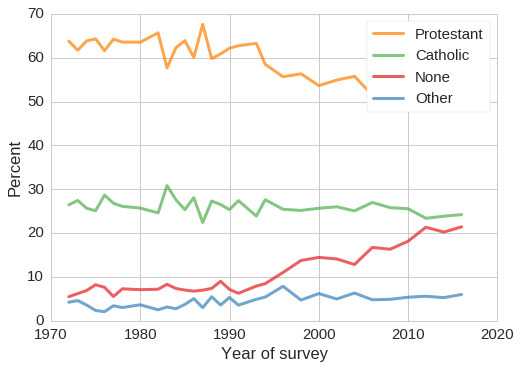

In [41]:
plot_relig(grouped_year)
thinkplot.config(xlabel='Year of survey', ylabel='Percent')

In [42]:
grouped_age = sample.groupby(['age_group'])

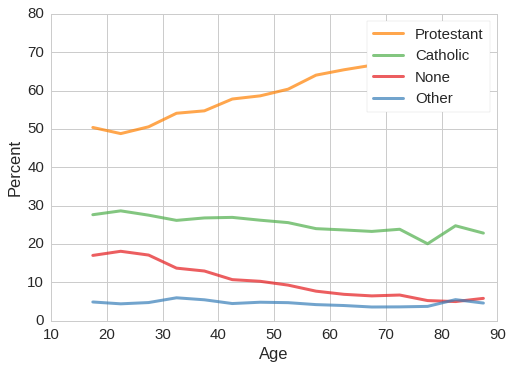

In [43]:
plot_relig(grouped_age)
thinkplot.config(xlabel='Age', ylabel='Percent')

Plot the percentage in each religious group as a function of birth cohort.

In [44]:
grouped_cohort = sample.groupby(['cohort5'])
#counts = grouped_cohort.relig.count()
#counts

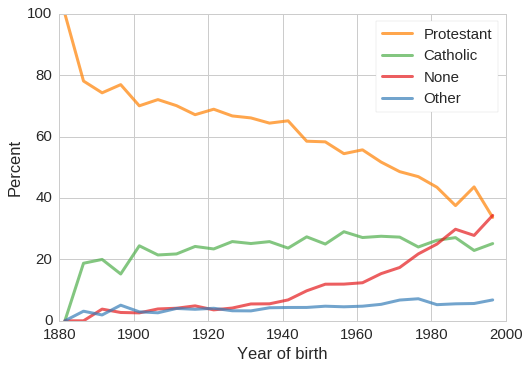

In [45]:
plot_relig(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent')

## Multinomial models

In [46]:
def make_multi_model(df, var, factors):
    """Fit a multinomial logistic regression model.
    
    df: DataFrame
    var: string name of dependent variable
    factors: list of string names for factors
    
    returns: MNLogit model
    """
    # TODO: investigate the missing=drop option
    nonull = df.dropna(subset=factors+[var])
    y = nonull[var].values
    X = nonull[factors].values
    return MNLogit(y, X).fit(disp=False, full_output=False)

In [47]:
def predict_multi_model(age, model, year, factors, index):
    """Make a single-year prediction.
    
    age: Series of ages to simulate
    model: MNLogit model
    year: year to make a prediction for
    factors: list of string names for factors
    index: list of strings, index of result Series
    
    returns: Series that maps index to percentage
    """
    # resample the ages
    n = len(age)
    age = np.random.choice(age, n, replace=True)
    
    # generate ages and cohort
    cohort = year - age
    df = pd.DataFrame(dict(cohort=cohort, age=age))
    center_factors(df)
    
    # compute probabilities in each category for each respondent
    X = df[factors].values
    pred = model.predict(X)
    
    # simplification:
    # assume that all respondents have the mean probability for
    # each category, and sample from the multinomial distribution
    means = pred.mean(axis=0)
    freqs = np.random.multinomial(n, means) / n
    
    # here's the version that doesn't use the simplification.
    # it's slower.
    
    # xs = np.arange(1, model.model.J+1)
    # func = lambda row: np.random.choice(xs, p=row)
    # choices = np.apply_along_axis(func, 1, pred)
    # _, counts = np.unique(choices, return_counts=True)
    # freqs = counts / n

    return pd.Series(freqs, index=index) * 100

In [48]:
train_year = 2016
train = sample[sample.year <= train_year]

In [49]:
factors = ['ones', 'a', 'c']
model = make_multi_model(train, 'relig4', factors)

In [50]:
age = sample.loc[sample.year==train_year, 'age']
index = ['prot', 'cath', 'other', 'none']

In [51]:
predict_multi_model(age, model, 1976, factors, index)

prot     65.208260
cath     26.006300
other     3.290165
none      5.495275
dtype: float64

In [52]:
predict_multi_model(age, model, 2016, factors, index)

prot     47.112356
cath     25.376269
other     5.495275
none     22.016101
dtype: float64

In [53]:
predict_multi_model(age, model, 2026, factors, index)

prot     42.912146
cath     22.471124
other     7.280364
none     27.336367
dtype: float64

In [54]:
predict_multi_model(age, model, 2036, factors, index)

prot     35.666783
cath     19.915996
other     7.630382
none     36.786839
dtype: float64

In [55]:
def make_multi_pred(df, var, varnames, train_year, years, factors, index):
    """Generate predictions from multinomial model.
    
    df: DataFrame of respondents
    var: dependent variable
    varnames: list of string variable names
    train_year: upper bound or (low, high) tuple for years of data
    years: sequence of years to generate predictions for
    factors: list of string factor names for the model
    index: index for the resulting DataFrame
    
    returns: DataFrame that maps from index to predicted values
    """
    try:
        low, high = train_year
    except TypeError:
        low = 0
        high = train_year
        
    train = df[(df.year >= low) & (df.year <= high)]
    age = df.loc[df.year==high, 'age']
    
    model = make_multi_model(train, var, factors)
    
    pred = pd.DataFrame(columns=varnames)
    for year in years:
        pred.loc[year] = predict_multi_model(age, model, year, factors, index)
    return pred

In [56]:
def plot_multi_pred(df, pred, varnames, colors, alpha=0.3):
    """Plots predictions from multinomial model.
    
    pred: DataFrame with one column per variable
    varnames: list of string variable names
    colors: list of string colors
    alpha: numerical transparency
    """
    series_seq = [pred[var] for var in varnames]
    for series, color in zip(series_seq, colors):
        thinkplot.plot(series, color=color, alpha=alpha)
    thinkplot.config(xlabel='Year of survey', loc='upper right')

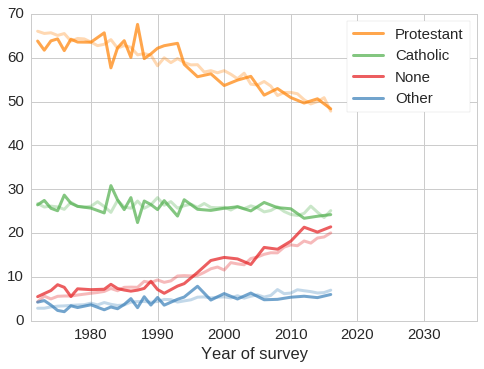

In [57]:
var = 'relig4'
varnames = ['prot', 'cath', 'none', 'other']
colors = [ORANGE, GREEN, RED, BLUE]
train_year = 2006
years = np.arange(1972, 2017)
factors = ['ones', 'a', 'c']
index = ['prot', 'cath', 'other', 'none']

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_relig(grouped_year)
thinkplot.config(xlim=[1971, 2038])

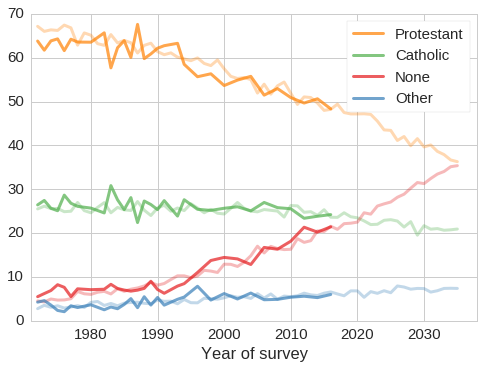

In [58]:
train_year = 2016
years = np.arange(1972, 2036)

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_relig(grouped_year)

thinkplot.config(xlim=[1971, 2038])

## Belief in God

I don't believe in God.....................1 

I don't know whether there is a God and I don''t believe there is any way to find out..................................2

I don't believe in a personal God, but I do believe in a Higher Power of some kind........................3 

I find myself believing in God some of the time, but not at others........4 

While I have doubts, I feel that I do believe in God….............................5 

I know God really exists and I have no doubts about it...........................6

In [59]:
def plot_beliefs(grouped):
    """Plot belief categories.
    
    grouped: GroupBy object
    """
    varnames = ['strongbelief', 'belief', 'nobelief']
    colors = [BLUE, PURPLE, RED]
    labels = ['Strong belief', 'Belief', 'No belief']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

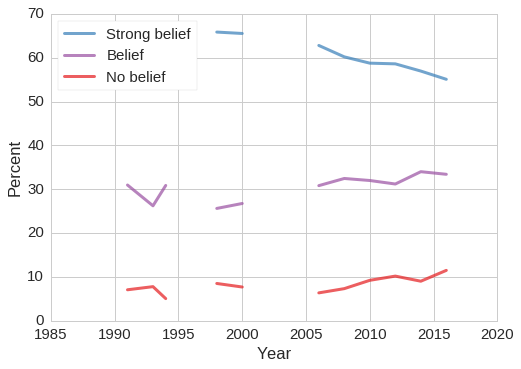

In [60]:
plot_beliefs(grouped_year)
thinkplot.config(xlabel='Year', ylabel='Percent', loc='upper left')

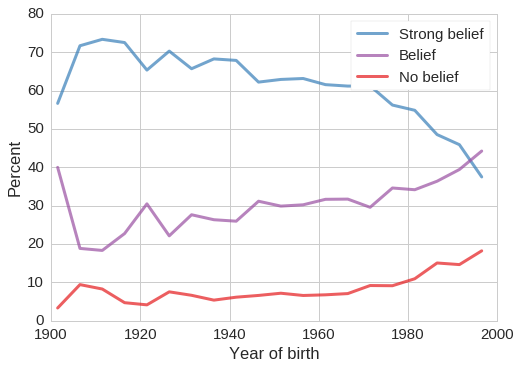

In [61]:
plot_beliefs(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [62]:
formula = 'belief3 ~ c + a'
model = smf.mnlogit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.863601
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                belief3   No. Observations:                22371
Model:                        MNLogit   Df Residuals:                    22365
Method:                           MLE   Df Model:                            4
Date:                Fri, 02 Jun 2017   Pseudo R-squ.:                0.008803
Time:                        12:42:32   Log-Likelihood:                -19320.
converged:                       True   LL-Null:                       -19491.
                                        LLR p-value:                 5.244e-73
==============================================================================
 belief3=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2526      0.034     36.869      0.000       1.186       1.319
c             -0.0151      0.003     -4.994      0.000      -0.021      -0.009
a             -0.0070      0.003     -2.119      0.034      -0.013      -0.001
------------------------------------------------------------------------------
 belief3=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8399      0.032     56.965      0.000       1.777       1.903
c             -0.0273      0.003     -9.511      0.000      -0.033      -0.022
a             -0.0089      0.003     -2.822      0.005      -0.015      -0.003
==============================================================================
"""

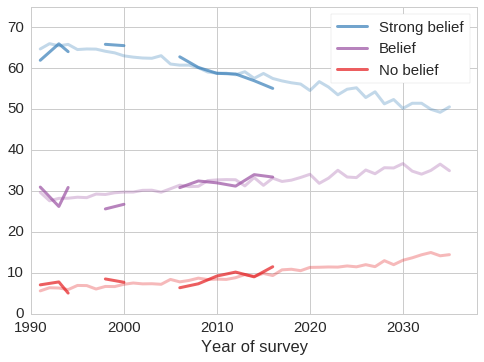

In [63]:
var = 'belief3'
varnames = ['strongbelief', 'belief', 'nobelief']
colors = [BLUE, PURPLE, RED]
train_year = 2016
years = np.arange(1991, 2036)
factors = ['ones', 'a', 'c']
index = ['nobelief', 'belief', 'strongbelief']

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_beliefs(grouped_year)

thinkplot.config(xlim=[1990, 2038], ylim=[0, 75])

In [64]:
make_multi_pred(sample, var, varnames, train_year, [1996, 2016, 2036], factors, index)

,strongbelief,belief,nobelief
1996,63.318166,31.326566,5.355268
2016,57.787889,32.131607,10.080504
2036,49.282464,36.156808,14.560728


## Confidence in people running organized religion

As far as the people running this institution [organized religion] are concerned, would you say you have a great deal of confidence, only some confidence, or hardly any confidence at all in them?

1. A great deal
2. Only some
3. Hardly any



In [65]:
def plot_conf(grouped):
    """Plot confidence in religion categories.
    
    grouped: GroupBy object
    """
    varnames = ['confident', 'someconf', 'noconf']
    colors = [BLUE, PURPLE, RED]
    labels = ['Great deal', 'Only some', 'Hardly any']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

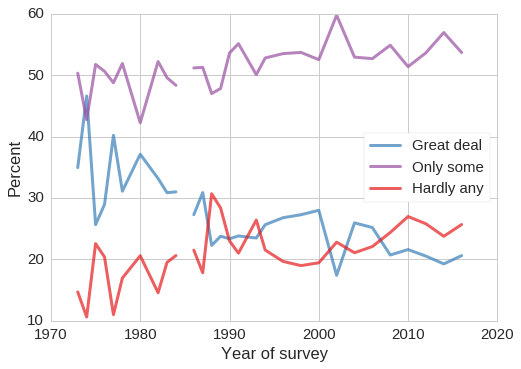

In [66]:
plot_conf(grouped_year)
thinkplot.config(xlabel='Year of survey', ylabel='Percent', loc='center right')

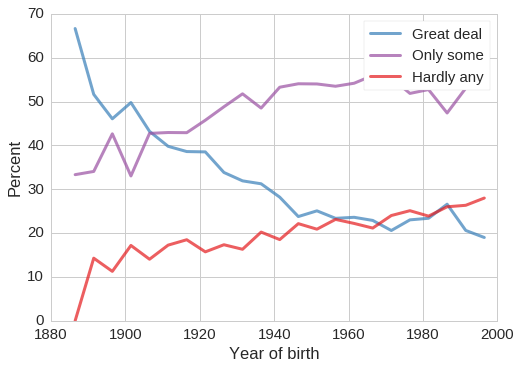

In [67]:
plot_conf(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

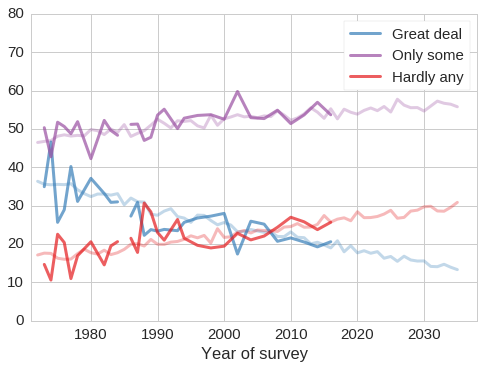

In [68]:
var = 'conclerg'
varnames = ['confident', 'someconf', 'noconf']
colors = [BLUE, PURPLE, RED]
train_year = 2016
years = np.arange(1972, 2036)
factors = ['ones', 'a', 'c']
index = varnames

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_conf(grouped_year)

thinkplot.config(xlim=[1971, 2038], ylim=[0, 80])

In [69]:
make_multi_pred(sample, var, varnames, train_year, [1976, 2016, 2036], factors, index)

,confident,someconf,noconf
1976,34.651733,49.037452,16.310816
2016,21.036052,53.202660,25.761288
2036,14.105705,55.757788,30.136507


## Bible

Which one of these statements comes closest to describing your feelings about the Bible? 

1. The Bible is the actual word of God and is to be taken literally, word for word

2. The Bible is the inspired word of God but not everything should be taken literally, word for word

3. The Bible is an ancient book of fables, legends, history and moral precepts recorded by man

In [70]:
def plot_bible(grouped):
    """Plot bible interpretation categories.
    
    grouped: GroupBy object
    """
    varnames = ['literal', 'inspired', 'legends']
    colors = [BLUE, PURPLE, RED]
    labels = ['Literal', 'Inspired', 'Legends']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

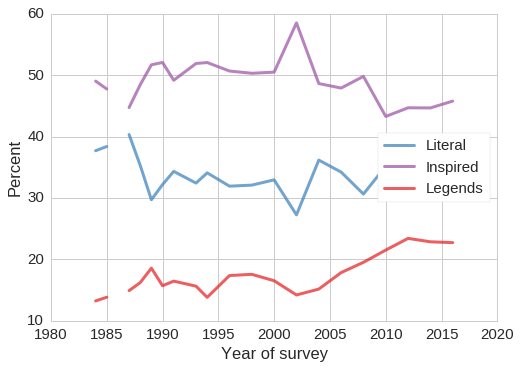

In [71]:
plot_bible(grouped_year)
thinkplot.config(xlabel='Year of survey', ylabel='Percent', loc='center right')

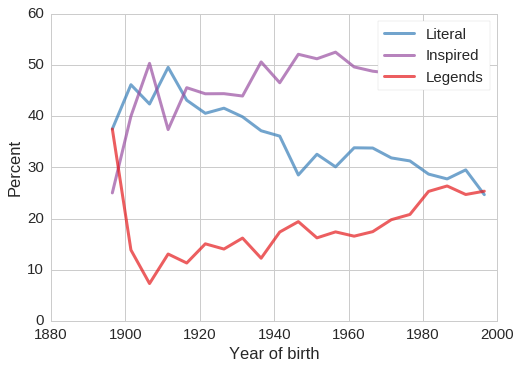

In [72]:
plot_bible(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

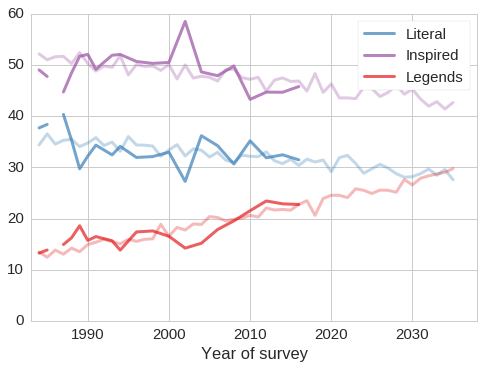

In [73]:
var = 'bible'
varnames = ['literal', 'inspired', 'legends']
colors = [BLUE, PURPLE, RED]
train_year = 2016
years = np.arange(1984, 2036)
factors = ['ones', 'a', 'c']
index = varnames

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_bible(grouped_year)

thinkplot.config(xlim=[1983, 2038], ylim=[0, 60])

In [74]:
make_multi_pred(sample, var, varnames, train_year, [1986, 2016, 2036], factors, index)

,literal,inspired,legends
1986,36.261813,50.472524,13.265663
2016,31.991600,45.117256,22.891145
2036,28.281414,41.232062,30.486524


## Resampling

In [75]:
#import age_religion
#gss = age_religion.read_gss()

In [76]:
def make_series_df(grouped, varnames):
    """Compute the percentage in each category.
    
    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names
    
    returns: DataFrame
    """
    df = pd.DataFrame(columns=varnames)
    for var in varnames:
        df[var] = grouped[var].mean() * 100
    return df

In [77]:
def percentile_rows(series_seq, ps):
    """Computes percentiles from aligned series.
    
    series_seq: list of sequences
    ps: cumulative probabilities
    
    returns: Series of x-values, NumPy array with selected rows
    """
    df = pd.concat(series_seq, axis=1).dropna()
    xs = df.index
    array = df.values.transpose()
    array = np.sort(array, axis=0)
    nrows, ncols = array.shape
    indices = (ps * nrows).astype(int)
    rows = array[indices]
    return xs, rows

In [78]:
def plot_percentiles(dfs, varnames, colors, labels, plot=True, fill=True):
    """Plots 90% CI and median.
    
    dfs: list of DataFrames
    varnames: list of string variable names
    colors: list of string colors
    labels: list of string labels
    plot: boolean, whether to plot the median
    fill: boolean, whether to plot the CI
    """
    ps = np.array([0.05, 0.5, 0.95])

    for var, color, label in zip(varnames, colors, labels):
        series_seq = [df[var] for df in dfs]
        xs, rows = percentile_rows(series_seq, ps)
        if fill:
            thinkplot.fill_between(xs, rows[0], rows[2], color=color, alpha=0.2)
        if plot:
            thinkplot.plot(xs, rows[1], color=color, label=label)

In [79]:
def run_data(df, groupvar, varnames, iters=101):
    """Resample and extract data.
    
    df: DataFrame
    groupvar: string variable to group by
    varnames: list of string variable names
    iters: number of resamples
    """
    def run():
        sample = utils.ResampleByYear(df)
        grouped_year = sample.groupby([groupvar])
        return make_series_df(grouped_year, varnames)

    dfs = [run() for _ in range(iters)]
    return dfs

In [80]:
def run_model(df, var, varnames, train_year, years, index, iters=101):
    """Resample and make predictions.
    
    df: DataFrame
    var: string variable name to model
    varnames: list of string variable names
    train_year: last year of data to use
    years: list of years to predict
    index: list of string variable names to extract
    iters: number of resamples
    """
    factors = ['ones', 'a', 'c']

    def run():
        sample = utils.ResampleByYear(df)
        return make_multi_pred(sample, var, varnames,
                               train_year, years, factors, index)

    dfs = [run() for _ in range(iters)]
    return dfs

## Affiliation

In [123]:
groupvar = 'year'
varnames = ['prot', 'cath', 'none', 'other']
dfs1 = run_data(gss, groupvar, varnames, iters=101)

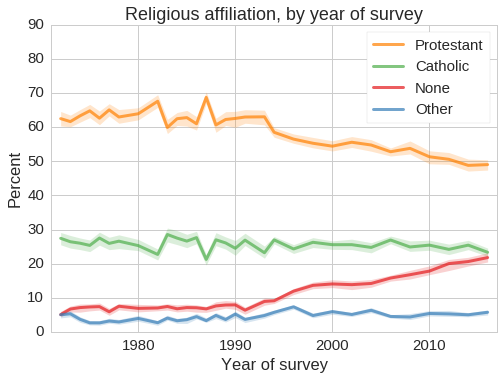

In [82]:
colors = [ORANGE, GREEN, RED, BLUE]
labels = ['Protestant', 'Catholic', 'None', 'Other']
plot_percentiles(dfs1, varnames, colors, labels)
thinkplot.config(title='Religious affiliation, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2017], ylim=[0, 90])

In [83]:
groupvar = 'cohort5'
dfs2 = run_data(gss, groupvar, varnames, iters=101)

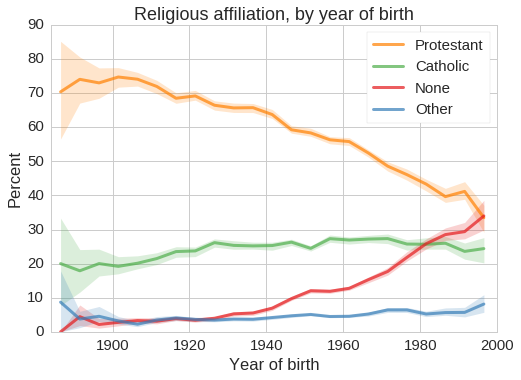

In [84]:
colors = [ORANGE, GREEN, RED, BLUE]
labels = ['Protestant', 'Catholic', 'None', 'Other']
plot_percentiles(dfs2, varnames, colors, labels)
thinkplot.config(title='Religious affiliation, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1884, 2000], yim=[0, 90])

Train with all data

In [85]:
var = 'relig4'
train_year = 2016
years = np.arange(1972, 2037)
factors = ['ones', 'a', 'c']
index = ['prot', 'cath', 'other', 'none']

dfs3 = run_model(gss, var, varnames, train_year, years, index, iters=101)

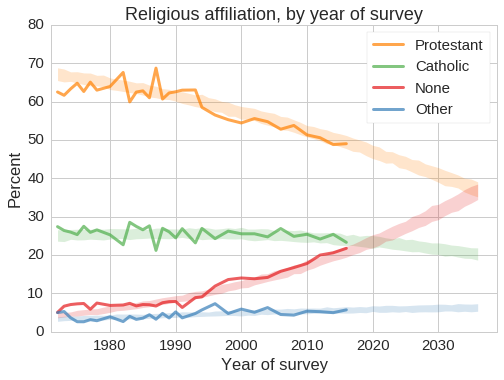

In [86]:
colors = [ORANGE, GREEN, RED, BLUE]
labels = ['Protestant', 'Catholic', 'None', 'Other']
nolabels= [None] * 4
plot_percentiles(dfs3, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Religious affiliation, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2039], ylim=[0, 80])

Train with data since 1990

In [130]:
var = 'relig4'
train_year = 1990, 2016
years = np.arange(1972, 2037)
factors = ['ones', 'a', 'c']
index = ['prot', 'cath', 'other', 'none']

dfs3 = run_model(gss, var, varnames, train_year, years, index, iters=101)

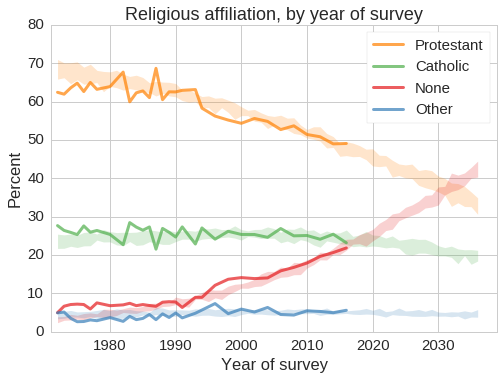

In [131]:
colors = [ORANGE, GREEN, RED, BLUE]
labels = ['Protestant', 'Catholic', 'None', 'Other']
nolabels= [None] * 4
plot_percentiles(dfs3, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Religious affiliation, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2039], ylim=[0, 80])

Train with data up to 2006

In [89]:
var = 'relig4'
train_year = 2006
factors = ['ones', 'a', 'c']

dfs4 = run_model(gss, var, varnames, train_year, years, index, iters=101)

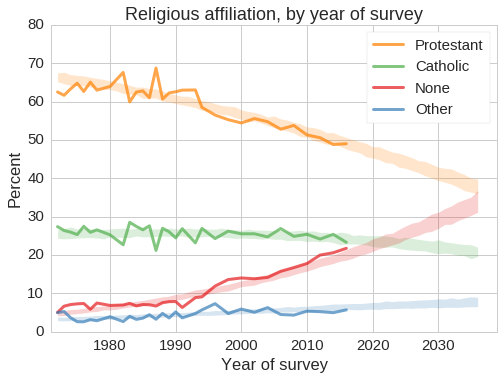

In [90]:
plot_percentiles(dfs4, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Religious affiliation, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2039], ylim=[0, 80])

Train with data up to 1996

In [91]:
train_year = 1996

dfs4 = run_model(gss, var, varnames, train_year, years, index, iters=101)

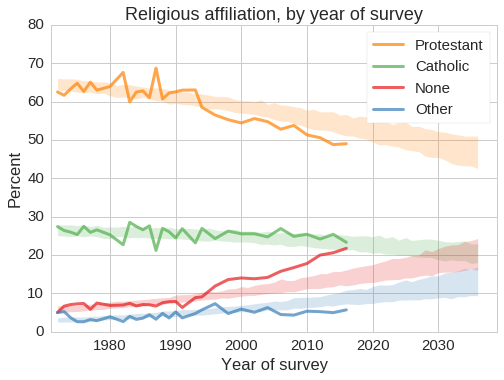

In [92]:
plot_percentiles(dfs4, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Religious affiliation, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2039], ylim=[0, 80])

In [93]:
ps = np.array([0.5])
series_seq = [df['other'] for df in dfs3]
xs, rows = percentile_rows(series_seq, ps)
series = pd.DataFrame(rows[0], index=xs)
series.loc[[1976, 1986, 1996, 2006, 2016]]

,0
1976,4.760238
1986,5.075254
1996,5.250263
2006,5.250263
2016,5.075254


## Beliefs

In [94]:
groupvar = 'year'
varnames = ['strongbelief', 'belief', 'nobelief']

In [95]:
dfs5 = run_data(gss, groupvar, varnames, iters=101)

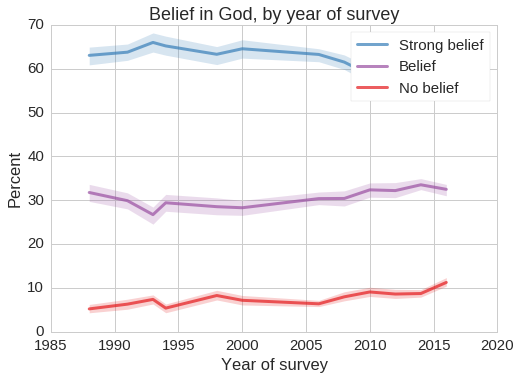

In [96]:
colors = [BLUE, PURPLE, RED]
labels = ['Strong belief', 'Belief', 'No belief']

plot_percentiles(dfs5, varnames, colors, labels)
thinkplot.config(title='Belief in God, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent')

In [97]:
groupvar = 'cohort5'
dfs6 = run_data(gss, groupvar, varnames, iters=101)

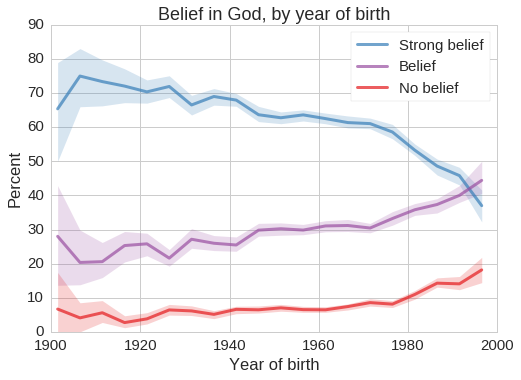

In [98]:
plot_percentiles(dfs6, varnames, colors, labels)
thinkplot.config(title='Belief in God, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                xlim=[1900, 2000], ylim=[0, 90])

In [99]:
var = 'belief3'
train_year = 2016
years = np.arange(1988, 2037)
factors = ['ones', 'a', 'c']
index = ['nobelief', 'belief', 'strongbelief']

In [100]:
dfs7 = run_model(gss, var, varnames, train_year, years, index, iters=101)

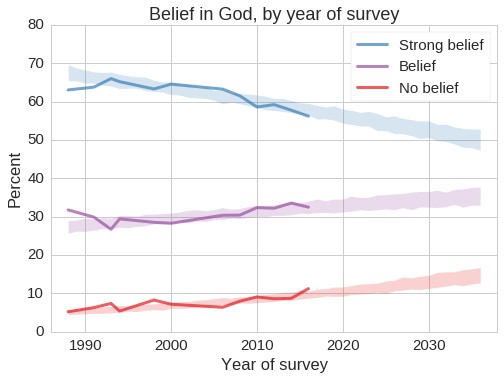

In [101]:
plot_percentiles(dfs7, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs5, varnames, colors, labels, fill=False)
thinkplot.config(title='Belief in God, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1986, 2038], ylim=[0, 80])

In [102]:
var = 'nobelief'
ps = np.array([0.5])
series_seq = [df[var] for df in dfs7]
xs, rows = percentile_rows(series_seq, ps)
series = pd.DataFrame(rows[0], index=xs)
series.loc[[1976, 1986, 1996, 2006, 2016, 2026, 2036]]

,0
1976,NaN
1986,NaN
1996,6.230312
2006,7.805390
2016,9.695485
2026,12.005600
2036,14.700735


## Confidence

In [103]:
groupvar = 'year'
varnames = ['confident', 'someconf', 'noconf']

In [104]:
dfs8 = run_data(gss, groupvar, varnames, iters=101)

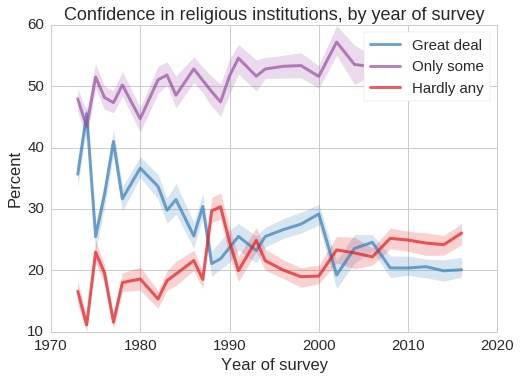

In [105]:
colors = [BLUE, PURPLE, RED]
labels = ['Great deal', 'Only some', 'Hardly any']

plot_percentiles(dfs8, varnames, colors, labels)
thinkplot.config(title='Confidence in religious institutions, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent')

In [106]:
groupvar = 'cohort5'
dfs9 = run_data(gss, groupvar, varnames, iters=101)

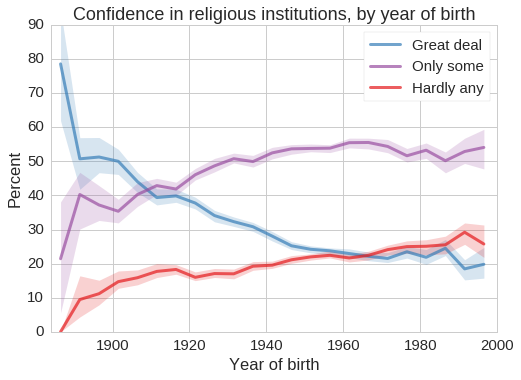

In [107]:
plot_percentiles(dfs9, varnames, colors, labels)
thinkplot.config(title='Confidence in religious institutions, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                xlim=[1884, 2000], ylim=[0, 90])

In [108]:
var = 'conclerg'
train_year = 2016
years = np.arange(1972, 2037)
factors = ['ones', 'a', 'c']
index = ['confident', 'someconf', 'noconf']

In [109]:
dfs10 = run_model(gss, var, varnames, train_year, years, index, iters=101)

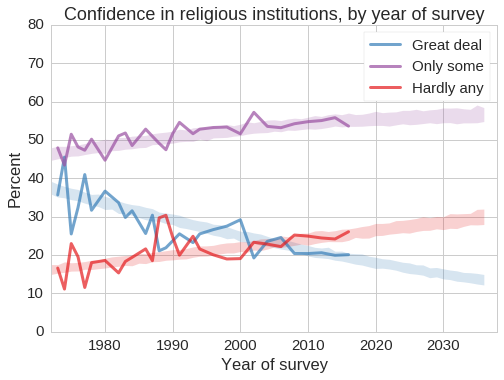

In [110]:
plot_percentiles(dfs10, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs8, varnames, colors, labels, fill=False)
thinkplot.config(title='Confidence in religious institutions, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1972, 2038], ylim=[0, 80])

In [111]:
var = 'noconf'
ps = np.array([0.5])
series_seq = [df[var] for df in dfs10]
xs, rows = percentile_rows(series_seq, ps)
series = pd.DataFrame(rows[0], index=xs)
series.loc[[1976, 1986, 1996, 2006, 2016, 2026, 2036]]

,0
1976,17.150858
1986,19.320966
1996,21.281064
2006,23.661183
2016,25.446272
2026,27.756388
2036,29.716486


## Bible

In [112]:
groupvar = 'year'
varnames = ['inspired', 'literal', 'legends']

In [113]:
dfs11 = run_data(gss, groupvar, varnames, iters=101)

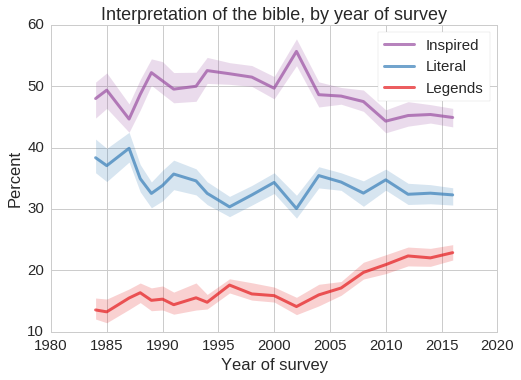

In [114]:
colors = [PURPLE, BLUE, RED]
labels = ['Inspired', 'Literal', 'Legends']

plot_percentiles(dfs11, varnames, colors, labels)
thinkplot.config(title='Interpretation of the bible, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent')

In [115]:
groupvar = 'cohort5'
dfs12 = run_data(gss, groupvar, varnames, iters=101)

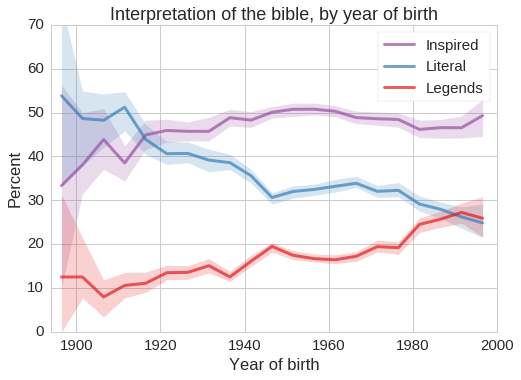

In [116]:
plot_percentiles(dfs12, varnames, colors, labels)
thinkplot.config(title='Interpretation of the bible, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                xlim=[1894, 2000], ylim=[0, 70])

In [117]:
var = 'bible'
train_year = 2016
years = np.arange(1984, 2037)
factors = ['ones', 'a', 'c']
index = ['literal', 'inspired', 'legends']

In [118]:
dfs13 = run_model(gss, var, varnames, train_year, years, index, iters=101)

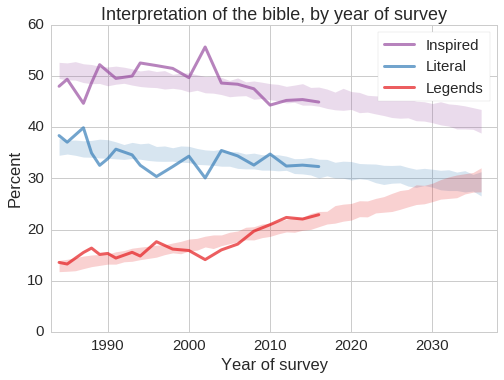

In [119]:
plot_percentiles(dfs13, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs11, varnames, colors, labels, fill=False)
thinkplot.config(title='Interpretation of the bible, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1983, 2038], ylim=[0, 60])

In [120]:
var = 'legends'
ps = np.array([0.5])
series_seq = [df[var] for df in dfs13]
xs, rows = percentile_rows(series_seq, ps)
series = pd.DataFrame(rows[0], index=xs)
series.loc[[1976, 1986, 1996, 2006, 2016, 2026, 2036]]

,0
1976,NaN
1986,13.195660
1996,15.820791
2006,18.725936
2016,22.086104
2026,25.656283
2036,29.891495
